In [1]:
### This began with a great head start from Johnowhitaker:
### https://zindi.africa/competitions/fowl-escapades/discussions/675

In [2]:
### And the first serious attempt to ensure I can reproduce identical results with a FastAI model & notebook
### the jupyter notebook was started with this command:
### env PYTHONHASHSEED=42 jupyter notebook
### per this FastAI thread: 
### https://forums.fast.ai/t/solved-reproducibility-where-is-the-randomness-coming-in/31628/15

In [3]:
### next step in reproducibility is to set up the various seeds within the notebook
### and this will need to be called:
###  You have to run random_seed(0), before the first fit;
###  You have to run it before creating the databunch;
###  And you have to call it every time for each different time you call fit.

def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [4]:
!ls

blend_f18f.csv			      fastai_v7.csv
blend_f18f_v2.csv		      five-sec-samples.ipynb
blend_f18f_v3.csv		      models
blend.R				      repro-fowl-A17a.ipynb
blend_v6_v7.csv			      repro-fowl-A17a-v2.ipynb
colab-follow-along.ipynb	      repro-fowl-A17b.ipynb
colab-improve-try1.ipynb	      repro-fowl-A17c.ipynb
colab-improve-try2.ipynb	      repro-fowl-data-creation.ipynb
colab-improve-try3-rn34.ipynb	      Rsplits
colab-improve-try4-rn50.ipynb	      Rsplits_Test
colab-improve-try5-rn50v2.ipynb       Rsplits_Train
colab-improve-try6-densenet201.ipynb  R_splitter.R
day1.R				      SampleSubmission.csv
default_plus_WBSR.csv		      splits_max_prob_row.csv
default_sub.csv			      StarterNotebook.ipynb
fastai_A17a.csv			      Test
fastai_A17av2.csv		      Test.csv
fastai_A17b.csv			      TestSplits.csv
fastai_f18c.csv			      Test_Wavs
fastai_f18d.csv			      Test.zip
fastai_f18e.csv			      Train
fastai_f18f.csv			      Train.csv
fastai_follow_along.csv		      Train_Cuts
fastai_splits_v1.csv

In [5]:
import pandas as pd
sub = pd.read_csv('SampleSubmission.csv')
sub.head()

,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,...,Karoo Scrub Robin,White-browed Scrub Robin,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting
0,019OYB,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,01S9OX,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,02CS12,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,02LM3W,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0C3A2V,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
train = pd.read_csv('Train.csv')
train.head()

,ID,common_name
0,MBMG2C,Ring-necked Dove
1,K8LJSB,Ring-necked Dove
2,OGD9L6,Ring-necked Dove
3,581PCQ,Ring-necked Dove
4,P91M1F,Ring-necked Dove


In [7]:
birds = sub.columns[1:]
birds

Index(['Ring-necked Dove', 'Black Cuckoo', 'Red-chested Cuckoo',
       'Fiery-necked Nightjar', 'Green Wood Hoopoe', 'Crested Barbet',
       'Cape Batis', 'Olive Bushshrike', 'Orange-breasted Bushshrike',
       'Bokmakierie', 'Black-backed Puffback', 'Southern Boubou',
       'Black-headed Oriole', 'Fork-tailed Drongo',
       'African Paradise Flycatcher', 'Sabota Lark', 'Eastern Clapper Lark',
       'Rufous-naped Lark', 'Dark-capped Bulbul', 'Sombre Greenbul',
       'Long-billed Crombec', 'African Reed Warbler', 'Rattling Cisticola',
       'Levaillants Cisticola', 'Tawny-flanked Prinia', 'Karoo Prinia',
       'Bar-throated Apalis', 'Green-backed Camaroptera',
       'Chestnut-vented Warbler', 'Cape White-eye', 'Karoo Scrub Robin',
       'White-browed Scrub Robin', 'Cape Robin-Chat',
       'White-browed Robin-Chat', 'Chorister Robin-Chat',
       'Southern Double-collared Sunbird', 'White-bellied Sunbird',
       'African Pipit', 'African Rock Pipit', 'Cape Bunting'],
      d

In [8]:
# Add file names
train['file_name'] = 'Train/'+train['ID']+'.mp3'
sub['file_name'] = 'Test/'+sub['ID']+'.mp3'

In [9]:
import IPython.display as ipd
from matplotlib import pyplot as plt
import librosa

In [10]:
# Checking that the spectrograms were generated successfully:
import glob
ims = glob.glob('Train/*.png')
train['img_path'] = train['file_name'].str[:-4]+'.png'
print(len(ims), len(train))

1857 1857


In [11]:
# Similarly, test now has rows for files that have had spectrograms created.
sub['img_path'] = sub['file_name'].str[:-4]+'.png'
ims = glob.glob('Test/*.png')
test = sub.loc[sub.img_path.isin(ims)]
print(len(sub), len(test))

911 911


In [12]:
from fastai.vision import *

In [13]:
random_seed(42,use_cuda=True)

data = ImageDataBunch.from_df(path="./", df=train[["img_path", "common_name"]], ds_tfms=get_transforms(), size=224, num_workers=0)\
  .split_by_rand_pct(valid_pct=0.04, seed=42)\
  .label_from_df(cols='common_name')\
  .databunch(bs=16)\
  .normalize(imagenet_stats)

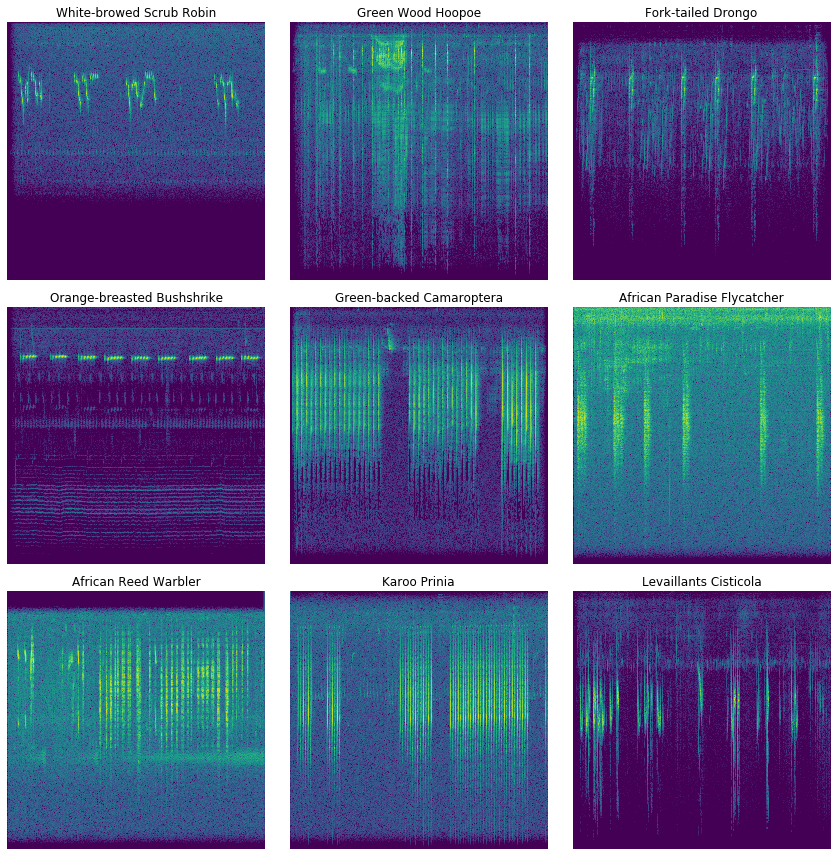

In [14]:
data.show_batch(rows=3)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


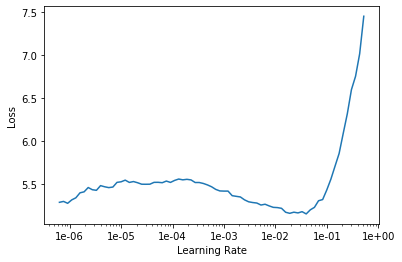

In [15]:
# Going to set this a lot
random_seed(42,use_cuda=True)

# Create a learner and pick a learning rate
learn = cnn_learner(data, models.resnet50, metrics=[error_rate, accuracy, top_k_accuracy])
learn.lr_find()
learn.recorder.plot()

In [16]:
# Going to set this a lot
random_seed(42,use_cuda=True)

# Train the head of the model
learn.fit_one_cycle(4, 5e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,6.082767,7.928716,0.966102,0.033898,0.135593,00:34
1,4.346562,3.827884,0.847458,0.152542,0.355932,00:35
2,3.300791,2.560129,0.694915,0.305085,0.661017,00:34
3,2.511320,2.092987,0.576271,0.423729,0.745763,00:34


In [17]:
# Going to set this a lot
random_seed(42,use_cuda=True)

learn.fit_one_cycle(4, 1e-2)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,2.075514,2.324317,0.627119,0.372881,0.745763,00:36
1,1.910523,2.368933,0.644068,0.355932,0.694915,00:35
2,1.403984,1.744840,0.457627,0.542373,0.813559,00:35
3,1.354423,1.564230,0.406780,0.593220,0.847458,00:34


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


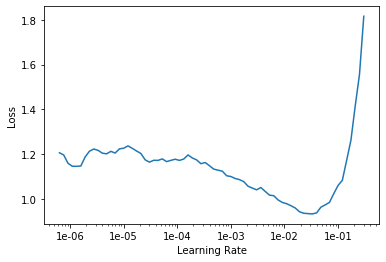

In [18]:
# Going to set this a lot
random_seed(42,use_cuda=True)

learn.lr_find()
learn.recorder.plot()

In [19]:
# Going to set this a lot
random_seed(42,use_cuda=True)

learn.fit_one_cycle(4, 1e-3)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.810265,1.515962,0.355932,0.644068,0.830508,00:35
1,0.372358,1.551197,0.389830,0.610169,0.830508,00:35
2,0.234311,1.502131,0.372881,0.627119,0.830508,00:35
3,0.785792,1.522615,0.372881,0.627119,0.813559,00:34


In [20]:
# Going to set this a lot
random_seed(42,use_cuda=True)

learn.fit_one_cycle(4, 1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.474400,1.495855,0.372881,0.627119,0.847458,00:35
1,0.168140,1.489400,0.372881,0.627119,0.847458,00:35
2,0.130016,1.481106,0.355932,0.644068,0.830508,00:34
3,0.725833,1.526944,0.372881,0.627119,0.847458,00:34


In [21]:
# Going to set this a lot
random_seed(42,use_cuda=True)

learn.fit_one_cycle(4, 1e-5)

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.442480,1.502854,0.355932,0.644068,0.847458,00:34
1,0.153993,1.492138,0.372881,0.627119,0.847458,00:34
2,0.122358,1.479887,0.355932,0.644068,0.830508,00:34
3,0.720231,1.527213,0.355932,0.644068,0.847458,00:34


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


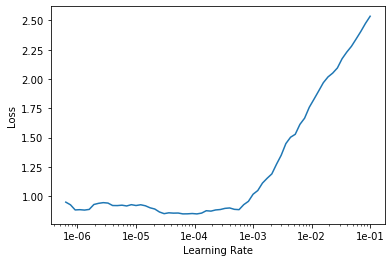

In [22]:
# Going to set this a lot
random_seed(42,use_cuda=True)

learn.save('stage-1')
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [23]:
# Going to set this a lot
random_seed(42,use_cuda=True)

learn.fit_one_cycle(4, slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.439885,1.493547,0.355932,0.644068,0.847458,00:47
1,0.152698,1.489313,0.355932,0.644068,0.847458,00:47
2,0.120910,1.478115,0.338983,0.661017,0.813559,00:47
3,0.700122,1.519352,0.355932,0.644068,0.830508,00:47


epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


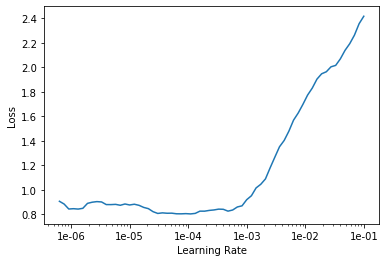

In [24]:
# Going to set this a lot
random_seed(42,use_cuda=True)

learn.lr_find()
learn.recorder.plot()

In [25]:
# Going to set this a lot
random_seed(42,use_cuda=True)

learn.fit_one_cycle(4, slice(5e-7, 5e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,0.408080,1.484001,0.355932,0.644068,0.847458,00:47
1,0.138618,1.482288,0.338983,0.661017,0.847458,00:47
2,0.109518,1.470308,0.372881,0.627119,0.830508,00:46
3,0.662303,1.508805,0.355932,0.644068,0.830508,00:47


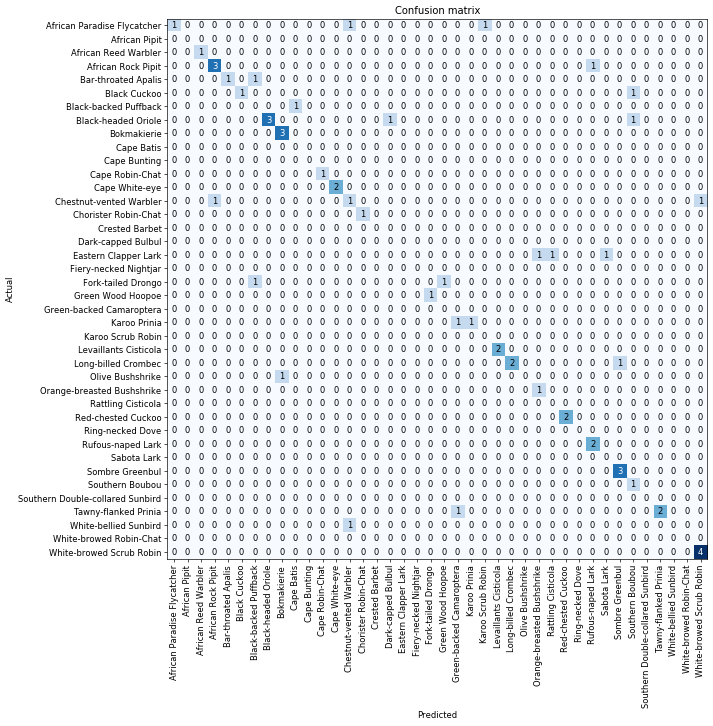

In [26]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [27]:
# Going to set this a lot
random_seed(42,use_cuda=True)

# Add the test data as a test set for the model
src = (ImageList.from_df(path='./', df=test, cols='img_path')) # Note test, not sub, as we only have spectrograms for the ims in test
learn.data.add_test(src)

In [28]:
# Get predictions
preds, y = learn.get_preds(DatasetType.Test)

In [29]:
# Add preds to test
test = test.copy()
for b in birds:
  test[b] = preds[:,learn.data.classes.index(b)]
test.head()

,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,...,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting,file_name,img_path
0,019OYB,0.000245,0.001635,0.007312,0.972097,0.000009,0.000007,0.000163,0.000145,0.000097,...,0.000005,0.005085,0.000593,5.212539e-08,8.504438e-08,2.914849e-08,0.000009,0.000003,Test/019OYB.mp3,Test/019OYB.png
1,01S9OX,0.000045,0.001278,0.001806,0.005091,0.000195,0.000035,0.018657,0.018171,0.004284,...,0.062922,0.013465,0.193648,8.223222e-05,6.941368e-05,1.703699e-05,0.006680,0.002943,Test/01S9OX.mp3,Test/01S9OX.png
2,02CS12,0.046008,0.001799,0.000025,0.005737,0.026356,0.024196,0.013522,0.001206,0.004355,...,0.015816,0.004505,0.000329,3.055451e-02,2.345427e-04,5.009284e-02,0.006536,0.125486,Test/02CS12.mp3,Test/02CS12.png
3,02LM3W,0.000590,0.012493,0.000280,0.000995,0.008532,0.001475,0.109853,0.660803,0.022111,...,0.000054,0.000094,0.017418,4.314383e-06,6.626351e-06,5.995940e-06,0.000009,0.000165,Test/02LM3W.mp3,Test/02LM3W.png
4,0C3A2V,0.000052,0.000191,0.000384,0.000323,0.001528,0.000018,0.000148,0.000638,0.000040,...,0.323472,0.032432,0.004561,5.927621e-05,5.439869e-04,3.562005e-05,0.000076,0.000207,Test/0C3A2V.mp3,Test/0C3A2V.png


In [30]:
# Merge back into submission DF, adding a low prob prediction for rows where we had no image generated
cols = ['ID']
for b in birds:
  cols.append(b)
ss = pd.merge(sub['ID'], test[cols], on='ID', how='left' )
ss = ss.fillna(1/40) # For those with NaNs (if you only generated spectrograms for a subset of the test mp3s)
ss.head()

,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,...,Karoo Scrub Robin,White-browed Scrub Robin,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting
0,019OYB,0.000245,0.001635,0.007312,0.972097,0.000009,0.000007,0.000163,0.000145,0.000097,...,3.668039e-08,0.000063,0.000005,0.005085,0.000593,5.212539e-08,8.504438e-08,2.914849e-08,0.000009,0.000003
1,01S9OX,0.000045,0.001278,0.001806,0.005091,0.000195,0.000035,0.018657,0.018171,0.004284,...,1.653073e-04,0.127325,0.062922,0.013465,0.193648,8.223222e-05,6.941368e-05,1.703699e-05,0.006680,0.002943
2,02CS12,0.046008,0.001799,0.000025,0.005737,0.026356,0.024196,0.013522,0.001206,0.004355,...,1.002264e-02,0.002967,0.015816,0.004505,0.000329,3.055451e-02,2.345427e-04,5.009284e-02,0.006536,0.125486
3,02LM3W,0.000590,0.012493,0.000280,0.000995,0.008532,0.001475,0.109853,0.660803,0.022111,...,2.118120e-05,0.000292,0.000054,0.000094,0.017418,4.314383e-06,6.626351e-06,5.995940e-06,0.000009,0.000165
4,0C3A2V,0.000052,0.000191,0.000384,0.000323,0.001528,0.000018,0.000148,0.000638,0.000040,...,5.812607e-04,0.010139,0.323472,0.032432,0.004561,5.927621e-05,5.439869e-04,3.562005e-05,0.000076,0.000207


In [31]:
# Check shape
ss.shape

(911, 41)

In [32]:
# Save predictions
ss.to_csv('fastai_A17c.csv', index=False)

# Save model
learn.save('model-A17c')

In [33]:
# LB Score v6: 1.55 (val loss 1.73)
# LB Score v7: 1.698 (val loss 1.71, but lower class accuracy)